In [2]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from scipy import signal
from scipy.misc import electrocardiogram
import os
from scipy.signal import find_peaks
import statistics

In [3]:
def read_csv_file(filename):
    with open(filename) as csvfile:
        spamreader = csv.reader(csvfile)
        input_data = np.empty([1600])
        for num, row in enumerate(spamreader):
            
            if num > 19:
                index = num - 20
                input_data[index] = row[3]
        
        return input_data

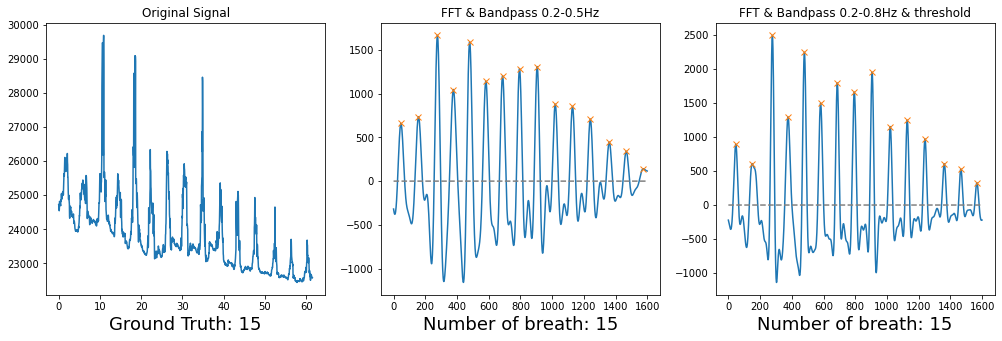

In [8]:
cvs_path = './001/001-15.csv'
rsp_y_ori = read_csv_file(cvs_path)
sampleRate = 26
high_pass = 0.2
low_pass = 0.8
height_thr = 0.15
distance_thr = 0.15

fig, axs = plt.subplots(1,3, figsize=(17, 5))

# Original signal
rsp_x=np.arange(0, rsp_y_ori.size) / sampleRate
gt = int(cvs_path.split('-')[1].split('.')[0])
axs[0].set_title("Original Signal")
axs[0].plot(rsp_x, rsp_y_ori)
axs[0].set_xlabel('Ground Truth: %d' % gt, fontsize=18)

# BandPass - # Previous results
wn=2*0.2/sampleRate
b, a = signal.butter(8, wn, 'highpass')   
rsp_y = signal.filtfilt(b, a, rsp_y_ori)

wn=2*0.5/sampleRate
b, a = signal.butter(8, wn, 'lowpass') 
rsp_y = signal.filtfilt(b, a, rsp_y)
peaks, _ = find_peaks(rsp_y, height=35,distance=30)

axs[1].set_title("FFT & Bandpass 0.2-0.5Hz")
axs[1].plot(rsp_y)
axs[1].plot(peaks, rsp_y[peaks], "x")
axs[1].plot(np.zeros_like(rsp_y), "--", color="gray")
axs[1].set_xlabel('Number of breath: %d' % len(peaks), fontsize=18)


# BandPass + threshold
wn=2*high_pass/sampleRate
b, a = signal.butter(8, wn, 'highpass')  
rsp_y = signal.filtfilt(b, a, rsp_y_ori)

wn=2*low_pass/sampleRate
b, a = signal.butter(8, wn, 'lowpass') 
rsp_y = signal.filtfilt(b, a, rsp_y)

peaks, _ = find_peaks(rsp_y, height=35,distance=30)

# Cal Height Threshold
height_peaks = rsp_y[peaks]
median = statistics.median(height_peaks)
height_thresh = int(height_thr*median)

# Cal Distance Threshold
distance = []
for i in range(1, len(peaks)):
    distance.append(peaks[i] - peaks[i-1])
distance = np.array(distance)
median_distance = statistics.median(distance)
distance_thresh = int(distance_thr*median_distance)

peaks, _ = find_peaks(rsp_y, height=height_thresh, distance=distance_thresh)

axs[2].set_title("FFT & Bandpass 0.2-0.8Hz & threshold")
axs[2].plot(rsp_y)
axs[2].plot(peaks, rsp_y[peaks], "x")
axs[2].plot(np.zeros_like(rsp_y), "--", color="gray")
axs[2].set_xlabel('Number of breath: %d' % len(peaks), fontsize=18)
plt.show()